In [1]:
#import module

import pandas
import pycaret
import numpy as np
import math
import matplotlib.pyplot as plt
from pycaret.regression import *
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from pycaret.regression import load_model

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

import time

In [2]:
#import module2

from py_module.load_data import load_data
from py_module.plot_data import plot_histogram

In [3]:
# import raw_data (from csv file)

filename = "./Data_2021_10_14_v1 (N98923)/Data.csv" # csv file directory and name

raw_data = load_data(fn=filename, pp=1)


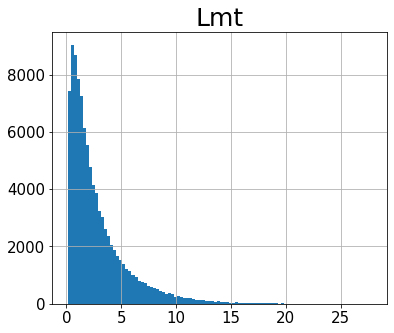

In [18]:
# plot raw_data histogram

# - parameter
# input : N1, N2, d1, d2, freq, move_tx, move_rx, offset_tx, offset_rx, per, space1, space2, space3, space4, l1, l2, h1, w1
# output : Lmt, Lmr, Llt, Llr, k, R1, R2

# - opt
# bins : (default : 100)
# plt_size : (default : [6,5])
# grid_en : (default : False)
# title_en : (default : False)
# title : (default : "")
# fontsize : (default : {}) (see : https://www.delftstack.com/ko/howto/matplotlib/how-to-set-the-figure-title-and-axes-labels-font-size-in-matplotlib/)

parameter = "Lmt"
title = parameter
fontsize = {'axes.titlesize' : 25, 'xtick.labelsize' : 15, 'ytick.labelsize' : 15}


plot_histogram(raw_data, parameter, grid_en=True, title_en=True, title=title, fontsize=fontsize)
